# Aim

General testing for sysid modifications.

In [1]:
# imports

import numpy as np
from scipy import optimize, signal, interpolate, stats
import matplotlib.pyplot as plt
import copy
import itertools
%matplotlib inline
from kalman import *

In [2]:
# run everything

pos = make_vibe_data() + make_atm_data()
pos_noisy = pos + np.random.normal(0, measurement_noise, times.size)
psd = get_psd(pos_noisy)
psd = noise_filter(psd)
params, variances = vibe_fit_freq(psd)

Text(0.5, 1.0, 'KF')

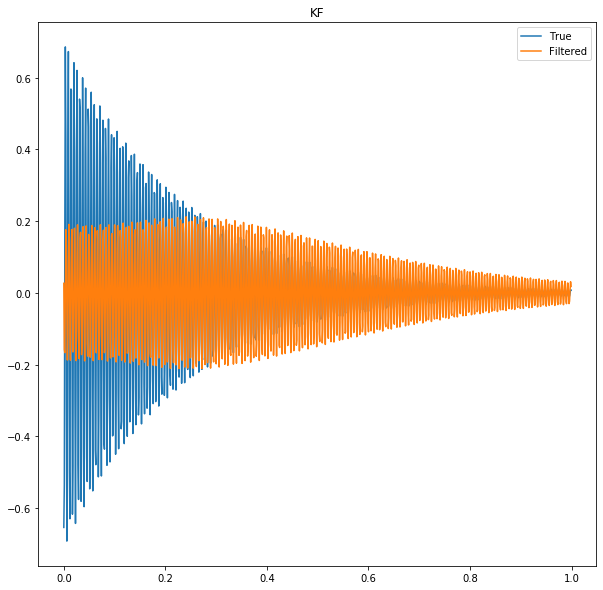

In [3]:
pos_k = kfilter(make_kfilter(params, variances), pos)
plt.figure(figsize=(10,10))
#plt.plot(times, pos_noisy, label='Measurements')
plt.plot(times, pos, label='True')
plt.plot(times, pos_k, label='Filtered')
#plt.plot(times, pos - pos_k, label='Residual')
plt.legend()
plt.title("KF")

In [6]:
def ekf_state_transition(state):
    dt = 1 / f_sampling
    assert not state.size % 4, "state includes N modes with p/v/a/b."
    A = np.zeros((state.size, state.size))
    N = state.size // 4
    for i in range(N):
        k = 4*i
        p, v, a, b = state[k:k+4]
        coeff = np.exp(a*dt)/b
        s, c = np.sin(b*dt), np.cos(b*dt)
        w2 = a**2 + b**2
        A[k][k]     = coeff * (-a * s + b * c)
        A[k][k+1]   = coeff * s
        A[k][k+2]   = coeff * ((b*dt*c - (a*dt + 1)*s) * p + dt * s * v)
        A[k][k+3]   = (coeff/b) * (((b**2 * dt - a)*s + a*b*c*dt)*p + (b*c*dt - s)*v)
        A[k+1][k]   = -coeff * w2 * s
        A[k+1][k+1] = coeff * (a * s + b * c)
        A[k+1][k+2] = coeff * (-s*(a**2 * dt + a + b**2 * dt)*p/np.sqrt(w2) + ((a*dt + 1)*s + b*dt*c)*v)
        A[k+1][k+3] = (coeff/b) * (((b**2 - a**2)*s + b*c*dt*(a**2 + b**2))*p + (a*b*c*dt - (a + b**2 * dt)*s)*v)
        A[k+2][k+2] = 1
        A[k+3][k+3] = 1
    return A

def ekf(params, variances, measurements):
    # takes in initial parameters and variances, and measurements
    # constructs and simulates an extended Kalman filter
    N = params.shape[0]
    STATE_SIZE = 4 * N
    P = np.zeros((STATE_SIZE, STATE_SIZE))
    Q = np.zeros((STATE_SIZE, STATE_SIZE))
    for i in range(variances.size):
        Q[4 * i][4 * i] = variances[i]
    H = np.array([[1, 0, 0, 0] * N])
    R = measurement_noise * np.identity(1)
    state = make_ekf_state(params)
    steps = int(f_sampling * time_id)
    pos_r = np.zeros(steps)
    for k in range(steps):
        state, P = update(H, P, R, state, measurements[k])
        pos_r[k] = H.dot(state)
        A = ekf_state_transition(state)
        if k == 1:
            print(A)
        state, P = predict(A, P, Q, state)
    return pos_r

[[ 4.42864267e-01  8.06006923e-04  1.25999431e-04 -9.21975366e-05]
 [-9.96884955e+02  4.42393940e-01  1.64338297e-01 -1.94158861e-01]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


Text(0.5, 1.0, 'EKF')

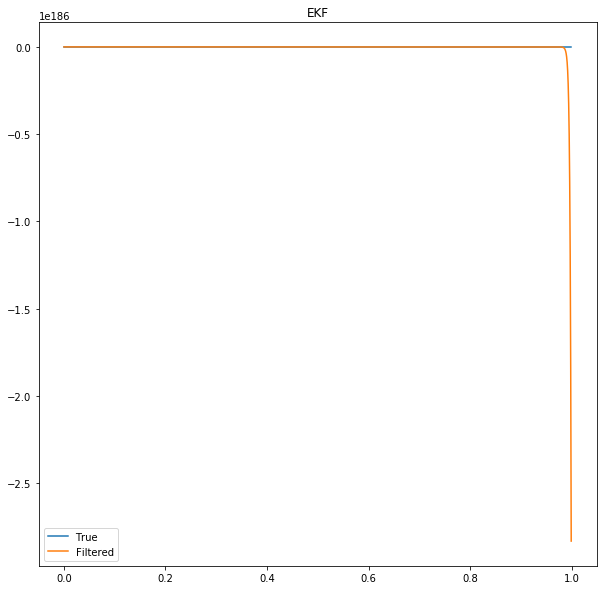

In [7]:
pos_ek = ekf(params, variances, pos_noisy)
plt.figure(figsize=(10,10))
#plt.plot(times, pos_noisy, label='Measurements')
plt.plot(times, pos, label='True')
plt.plot(times, pos_ek, label='Filtered')
#plt.plot(times, pos - pos_ek, label='Residual')
plt.legend()
plt.title("EKF")